# LSTM MODELS

In [13]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bshukla\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

DEFINE FILE PATH

In [25]:
# File paths
TRAIN_CSV = 'C:\\Users\\bshukla\\Desktop\\NLP_Project\\quora-question-pairs\\train.csv'
TEST_CSV = 'C:\\Users\\bshukla\\Desktop\\NLP_Project\\quora-question-pairs\\test.csv'
EMBEDDING_FILE = 'C:\\Users\\bshukla\\GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = 'C:\\Users\\bshukla\\Desktop\\NLP_Project'

LOAD TRAIN AND EMBEDDING DATASET 

In [26]:
# Retreive train and test model
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

stops = set(stopwords.words('english'))

# function to convert text to word,remove custom words, change misspelled words, spell short words out

def text_to_word_list(text):
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# loading the embeddings using the GoogleNews-vectors-negative300.bin.gz file 
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # Putting the embedding matrix together
embeddings[0] = 0  # to ignore padding

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

C:\Users\bshukla\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


SPLIT THE DATA INTO TRAIN AND VALIDATE

In [27]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# split into train and validate
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# create a dict for question 1 and question 2 and read into x_train, x_validation, and x_test 
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# retreive the values of the dict 
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Check the shape so it returns true
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

MALSTM MODEL WITH 2 EPOCHS

In [29]:
# Parameters
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 2

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# Visibe layer input
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embed the visible layer
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Encode left and right side the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Use the exponent_neg_manhattan_distance function to calculate the distance
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Put the model together with alll the specified parameters above
malstm = Model([left_input, right_input], [malstm_distance])

# Use gradient clipping by norm with adadelta optimizer for compilation
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Train & validation stats
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

C:\Users\bshukla\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 364290 samples, validate on 40000 samples
Epoch 1/2
364290/364290 [==============================] - 8075s 22ms/step - loss: 0.1747 - acc: 0.7458 - val_loss: 0.1601 - val_acc: 0.7728
Epoch 2/2
364290/364290 [==============================] - 2332s 6ms/step - loss: 0.1546 - acc: 0.7824 - val_loss: 0.1513 - val_acc: 0.7897
Training time finished.
2 epochs in 2:53:28.425502


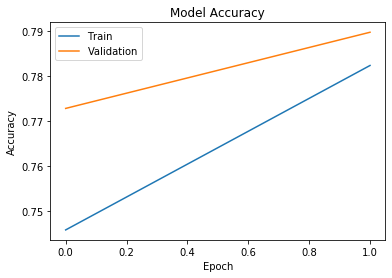

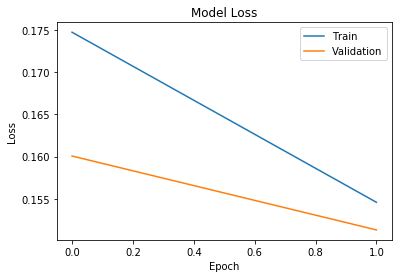

In [30]:

# accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# =loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

MALSTM MODEL WITH 5 EPOCHS

In [40]:
# Parameters
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 5

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# Visibe layer input
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embed the visible layer
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Encode left and right side the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Use the exponent_neg_manhattan_distance function to calculate the distance
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Put the model together with alll the specified parameters above
malstm = Model([left_input, right_input], [malstm_distance])

# Use gradient clipping by norm with adadelta optimizer for compilation
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Train & validation stats
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

C:\Users\bshukla\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 364290 samples, validate on 40000 samples
Epoch 1/5
364290/364290 [==============================] - 4048s 11ms/step - loss: 0.1744 - acc: 0.7462 - val_loss: 0.1654 - val_acc: 0.7692
Epoch 2/5
364290/364290 [==============================] - 2301s 6ms/step - loss: 0.1538 - acc: 0.7838 - val_loss: 0.1505 - val_acc: 0.7902
Epoch 3/5
364290/364290 [==============================] - 1802s 5ms/step - loss: 0.1464 - acc: 0.7957 - val_loss: 0.1470 - val_acc: 0.7958
Epoch 4/5
364290/364290 [==============================] - 1769s 5ms/step - loss: 0.1420 - acc: 0.8029 - val_loss: 0.1419 - val_acc: 0.8024
Epoch 5/5
364290/364290 [==============================] - 2056s 6ms/step - loss: 0.1387 - acc: 0.8078 - val_loss: 0.1395 - val_acc: 0.8047
Training time finished.
5 epochs in 3:19:40.165178


import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
    def on_train_begin(self, logs={}):
         self.val_f1s = []
         self.val_recalls = []
         self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return
 
metrics = Metrics()

In [ ]:
malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[metrics])

C:\Users\bshukla\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 364290 samples, validate on 40000 samples
Epoch 1/5
272064/364290 [=====================>........] - ETA: 8:15 - loss: 0.1367 - acc: 0.8103